In [ ]:
''''
#### CDS pricing ####

0. Merge CDS data with CRSP-Compustat data based on date gvkey and date. 
1. Impute missing values with median.
2. Keep only numerical variables.
3. Remove variables that are all missing.
4. Divide the dataset to test and train. Consider 2016, 2017, and 2018 data as test and the rest as train.
5. On the train sample run a Random Forest with 50 trees (note that it may take a while)
6. Keep the first 50 features with highest feature importance and discard the rest from both test and train.
7. Using these 50 variables run Random Forest, Gradient Boosting, and XGBoost with 100, 200, 500, and 1000 trees.
8. Show the relationship between number of trees and “Mean Squared Error” of test sample in a line graph. Show the results of all three techniques in a single graph.

''''

In [2]:
import pandas as pd
import numpy as np

In [3]:
# read compustat file and add columns of 'year' and 'month' to help create the 'period' for merging
CRSPdata = pd.read_csv('Quarterly Merged CRSP-Compustat.csv')

CRSPdata.columns = map(str.lower, CRSPdata.columns)

CRSPdata['year'] = pd.DatetimeIndex(CRSPdata['datadate']).year
CRSPdata['month'] = pd.DatetimeIndex(CRSPdata['datadate']).month

CRSPdata['quarter'] = np.where( CRSPdata['month'].isin([1,2,3]), 'Q1', '')
CRSPdata['quarter'] = np.where( CRSPdata['month'].isin([4,5,6]), 'Q2', CRSPdata['quarter'])
CRSPdata['quarter'] = np.where( CRSPdata['month'].isin([7,8,9]), 'Q3', CRSPdata['quarter'])
CRSPdata['quarter'] = np.where( CRSPdata['month'].isin([10,11,12]), 'Q4', CRSPdata['quarter'])
CRSPdata['match_period'] = CRSPdata['year'].astype(str) + CRSPdata['quarter']

CRSPdata.head(5)

C:\Users\duck7\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2,33,37,654,655,656,657,661,675,676,686) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gvkey,linkprim,liid,linktype,lpermno,lpermco,linkdt,linkenddt,datadate,fyearq,...,spcsrc,state,stko,weburl,dldte,ipodate,year,month,quarter,match_period
0,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,03/31/2001,2000,...,NaN,MO,0.0,www.amctheatres.com,12/27/2004,NaN,2001,3,Q1,2001Q1
1,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,06/30/2001,2001,...,NaN,MO,0.0,www.amctheatres.com,12/27/2004,NaN,2001,6,Q2,2001Q2
2,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,09/30/2001,2001,...,NaN,MO,0.0,www.amctheatres.com,12/27/2004,NaN,2001,9,Q3,2001Q3
3,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,12/31/2001,2001,...,NaN,MO,0.0,www.amctheatres.com,12/27/2004,NaN,2001,12,Q4,2001Q4
4,1038,P,1,LU,66413,6301,08/18/1983,12/31/2004,03/31/2002,2001,...,NaN,MO,0.0,www.amctheatres.com,12/27/2004,NaN,2002,3,Q1,2002Q1


In [4]:
# seperate the firms which has different ends of quarters in compustat file into three lists called 'type1', 'type2' and 'type3'
# type 1: firms with months of quaters ends at 1,4,7,10  
# type 2: firms with months of quaters ends at 2,5,8,11  
# type 3: firms with months of quaters ends at 3,6,9,12  
# later use these lists to help divide CDS dataframe into 4 sub-dataframes 
s = CRSPdata[['gvkey','month']]
s = s.drop_duplicates(subset='gvkey', keep='first')

s1 = s.loc[s['month'].isin([1,4,7,10])]
s2 = s.loc[s['month'].isin([2,5,8,11])]
s3 = s.loc[s['month'].isin([3,6,9,12])]

type1 = s1['gvkey'].tolist()
type2 = s2['gvkey'].tolist()
type3 = s3['gvkey'].tolist()
alltype = CRSPdata['gvkey'].unique().tolist()

print(len(type1)+len(type2)+len(type3))
print(len(alltype))

1199
1199


In [5]:
# read the CDS file and add columns of 'year' and 'month'
data = pd.io.stata.read_stata('cds_spread5y_2001_2016.dta')
data.to_csv('cds_spread5y_2001_2016.csv')
cdsdata = pd.read_csv('cds_spread5y_2001_2016.csv')

cdsdata['year'] = pd.DatetimeIndex(cdsdata['mdate']).year
cdsdata['month'] = pd.DatetimeIndex(cdsdata['mdate']).month
cdsdata.head(5)

,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating,year,month
0,0,1038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.042000,BB,2004,8
1,1,1038,2005-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034000,BB,2005,8
2,2,1038,2005-09-30,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034000,BB,2005,9
3,3,1038,2005-10-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034001,BB,2005,10
4,4,1038,2005-11-30,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034001,BB,2005,11


In [6]:
# divide CDS dataframe into 4 sub-dataframes by type1, type2 and type3 lists
df1 = cdsdata[cdsdata['gvkey'].isin(type1)].reset_index() # sub-dataframe by type1
df2 = cdsdata[cdsdata['gvkey'].isin(type2)].reset_index() # sub-dataframe by type2
df3 = cdsdata[cdsdata['gvkey'].isin(type3)].reset_index() # sub-dataframe by type3
df4 = cdsdata[~cdsdata['gvkey'].isin(alltype)].reset_index() # store the rest of firms

print( len(df1)+len(df2)+len(df3)+len(df4) == len(cdsdata))

True


In [7]:
# create column 'match_period' for later merging 
df1['quarter'] = np.where( df1['month'].isin([1,2,3]), 'Q1', '')
df1['quarter'] = np.where( df1['month'].isin([4,5,6]), 'Q2', df1['quarter'])
df1['quarter'] = np.where( df1['month'].isin([7,8,9]), 'Q3', df1['quarter'])
df1['quarter'] = np.where( df1['month'].isin([10,11,12]), 'Q4', df1['quarter'])
df1['match_period'] = df1['year'].astype(str) + df1['quarter']

# merge the sub-dataframe by type1 with CRSPdata
df1_merged = pd.merge(df1, CRSPdata, on=['gvkey','match_period'], how='left')
df1_merged.head(3)

,index,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year_y,month_y,quarter_y
0,1545,1545,1240,2002-01-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005400,...,978.0,B+,ID,0.0,NaN,06/02/2006,NaN,2002.0,1.0,Q1
1,1546,1546,1240,2002-02-28,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005583,...,978.0,B+,ID,0.0,NaN,06/02/2006,NaN,2002.0,1.0,Q1
2,1547,1547,1240,2002-03-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005188,...,978.0,B+,ID,0.0,NaN,06/02/2006,NaN,2002.0,1.0,Q1


In [8]:
# create column 'match_period' for merging later
df2['quarter'] = np.where( df2['month'].isin([2,3,4]), 'Q1', '')
df2['quarter'] = np.where( df2['month'].isin([5,6,7]), 'Q2', df2['quarter'])
df2['quarter'] = np.where( df2['month'].isin([8,9,10]), 'Q3', df2['quarter'])
df2['quarter'] = np.where( df2['month'].isin([11,12,1]), 'Q4', df2['quarter'])
df2['year'] = np.where( df2['month']==1, df2['year']-1, df2['year'])
df2['match_period'] = df2['year'].astype(str) + df2['quarter']

# merge the sub-dataframe by type2 with CRSPdata
df2_merged = pd.merge(df2, CRSPdata, on=['gvkey','match_period'], how='left')
df2_merged.head(3)

,index,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year_y,month_y,quarter_y
0,3446,3446,1468,2003-03-31,0C89AC,SNRFOR,AM,Amern Greetings Corp,MR,0.034447,...,976.0,B-,OH,0.0,www.americangreetings.com,08/09/2013,NaN,2003.0,2.0,Q1
1,3447,3447,1468,2003-05-31,0C89AC,SNRFOR,AM,Amern Greetings Corp,MR,0.032660,...,976.0,B-,OH,0.0,www.americangreetings.com,08/09/2013,NaN,2003.0,5.0,Q2
2,3448,3448,1468,2003-06-30,0C89AC,SNRFOR,AM,Amern Greetings Corp,MR,0.028160,...,976.0,B-,OH,0.0,www.americangreetings.com,08/09/2013,NaN,2003.0,5.0,Q2


In [9]:
# create column 'match_period' for merging later
df3['quarter'] = np.where( df3['month'].isin([3,4,5]), 'Q1', '')
df3['quarter'] = np.where( df3['month'].isin([6,7,8]), 'Q2', df3['quarter'])
df3['quarter'] = np.where( df3['month'].isin([9,10,11]), 'Q3', df3['quarter'])
df3['quarter'] = np.where( df3['month'].isin([12,1,2]), 'Q4', df3['quarter'])
df3['year'] = np.where( df3['month'].isin([1,2]), df3['year']-1, df3['year'])
df3['match_period'] = df3['year'].astype(str) + df3['quarter']

# merge the sub-dataframe by type3 with CRSPdata
df3_merged = pd.merge(df3, CRSPdata, on=['gvkey','match_period'], how='left')
df3_merged.head(3)

,index,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year_y,month_y,quarter_y
0,0,0,1038,2004-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,MR,0.042,...,978.0,NaN,MO,0.0,www.amctheatres.com,12/27/2004,NaN,2004.0,6.0,Q2
1,1,1,1038,2005-08-31,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,1038,2005-09-30,0A17CF,SNRFOR,AEN,AMC Entmt Inc,XR,0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# create column 'match_period' for merging later
df4['quarter'] = np.where( df4['month'].isin([1,2,3]), 'Q1', '')
df4['quarter'] = np.where( df4['month'].isin([4,5,6]), 'Q2', df4['quarter'])
df4['quarter'] = np.where( df4['month'].isin([7,8,9]), 'Q3', df4['quarter'])
df4['quarter'] = np.where( df4['month'].isin([10,11,12]), 'Q4', df4['quarter'])
df4['match_period'] = df4['year'].astype(str) + df4['quarter']

# merge the sub-dataframe by type4 with CRSPdata
df4_merged = pd.merge(df4, CRSPdata, on=['gvkey','match_period'], how='left')
df4_merged.head(3)

,index,Unnamed: 0,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,...,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year_y,month_y,quarter_y
0,1241,1241,1225,2004-12-31,0B13CB,SNRFOR,SO-ALPower,AL Pwr Co,MR,0.00165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1242,1242,1225,2005-01-31,0B13CB,SNRFOR,SO-ALPower,AL Pwr Co,MR,0.00165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1243,1243,1225,2005-02-28,0B13CB,SNRFOR,SO-ALPower,AL Pwr Co,MR,0.00165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# combine all the sub-dataframe together, called 'mydata'
final = pd.concat([df1_merged, df2_merged, df3_merged, df4_merged], ignore_index=True)

# drop the temporary columns
final = final.drop(['index','Unnamed: 0','year_y','month_y','quarter_y','year_x','month_x','quarter_x','match_period'], axis=1)
final

,gvkey,mdate,redcode,tier,ticker,shortname,docclause,spread5y,impliedrating,linkprim,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1240,2002-01-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005400,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
1,1240,2002-02-28,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005583,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
2,1240,2002-03-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005188,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
3,1240,2002-04-30,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005355,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
4,1240,2002-05-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.005242,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
5,1240,2002-06-30,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.007016,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
6,1240,2002-07-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.007252,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
7,1240,2002-08-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.008607,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
8,1240,2002-09-30,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.009096,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN
9,1240,2002-10-31,0B4414,SNRFOR,ABS,Albertsons Inc,MR,0.008798,BBB,P,...,1.0,5411.0,440.0,978.0,B+,ID,0.0,NaN,06/02/2006,NaN


In [12]:
# Impute missing values with median
mydata = final.fillna(final.median())

# Add one column to store year for later dividing into test and train
mydata['*year'] = mydata['mdate'].astype(str).str[0:4]
mydata['*year'] = pd.to_numeric(mydata['*year'])

# Keep only numerical variables
mydata = mydata._get_numeric_data()

# Remove variables that are all missing
mydata = mydata.dropna(axis='columns')

# Split the data into training and testing sets
Train = mydata[mydata['*year'] < 2016]
Test = mydata[mydata['*year'] >= 2016]

# Split into train_x and train_y
Train_Y = Train['spread5y']
Train_X = Train.drop('spread5y', axis=1)

Test_Y = Test['spread5y']
Test_X = Test.drop('spread5y', axis=1)

In [13]:
# Run a Random Forest with 50 trees on the train sample
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 50)
forest_fit = rf.fit(Train_X, Train_Y)

In [20]:
# Use the forest's predict method on the test data
predict_y = rf.predict(Test_X) 

# Returns the mean accuracy
print("Mean accuracy: ", forest_fit.score(Test_X, Test_Y))


Mean accuracy:  0.202194258712


In [47]:
# Find and keep the first 50 features with highest feature importance 
feature_importances = pd.DataFrame(forest_fit.feature_importances_,
                                   index = Train_X.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

# Discard the rest from both test and train.
new_Train_X = Train_X.loc[:,feature_importances.iloc[:50].index.values]
new_Test_X = Test_X.loc[:,feature_importances.iloc[:50].index.values]
print(new_Train_X.shape)
print(new_Test_X.shape)

(159964, 50)
(10997, 50)


In [50]:
# Use these 50 variables run Random Forest with 100, 200, 500, and 1000 trees.
rf_100 = RandomForestRegressor(n_estimators = 100)
rf_200 = RandomForestRegressor(n_estimators = 200)
rf_500 = RandomForestRegressor(n_estimators = 500)
rf_1000 = RandomForestRegressor(n_estimators = 1000)

rf_fit_100 = rf_100.fit(new_Train_X, Train_Y)
rf_fit_200 = rf_200.fit(new_Train_X, Train_Y)
rf_fit_500 = rf_500.fit(new_Train_X, Train_Y)
rf_fit_1000 = rf_1000.fit(new_Train_X, Train_Y)

print("Mean accuracy with 100 trees: ", rf_fit_100.score(new_Test_X, Test_Y))
print("Mean accuracy with 200 trees: ", rf_fit_200.score(new_Test_X, Test_Y))
print("Mean accuracy with 500 trees: ", rf_fit_500.score(new_Test_X, Test_Y))
print("Mean accuracy with 1000 trees: ", rf_fit_1000.score(new_Test_X, Test_Y))

#y_pred_rf100 = rf_100.predict(new_Test_X)
#y_pred_rf200 = rf_200.predict(new_Test_X)
#y_pred_rf500 = rf_500.predict(new_Test_X)
#y_pred_rf1000 = rf_1000.predict(new_Test_X)


Mean accuracy with 100 trees:  0.199091157743
Mean accuracy with 200 trees:  0.222890516806
Mean accuracy with 500 trees:  0.208532680642
Mean accuracy with 1000 trees:  0.212350108976


In [51]:
# Use these 50 variables run Gradient Boosting with 100, 200, 500, and 1000 trees.
from sklearn.ensemble import GradientBoostingRegressor

GB_100 = GradientBoostingRegressor(n_estimators = 100)
GB_200 = GradientBoostingRegressor(n_estimators = 200)
GB_500 = GradientBoostingRegressor(n_estimators = 500)
GB_1000 = GradientBoostingRegressor(n_estimators = 1000)


GB_fit_100 = GB_100.fit(new_Train_X, Train_Y)
GB_fit_200 = GB_200.fit(new_Train_X, Train_Y)
GB_fit_500 = GB_500.fit(new_Train_X, Train_Y)
GB_fit_1000 = GB_1000.fit(new_Train_X, Train_Y)

print("The accuracy score with 100 trees: ", GB_fit_100.score(new_Test_X, Test_Y))
print("The accuracy score with 200 trees: ", GB_fit_200.score(new_Test_X, Test_Y))
print("The accuracy score with 500 trees: ", GB_fit_500.score(new_Test_X, Test_Y))
print("The accuracy score with 1000 trees: ",GB_fit_1000.score(new_Test_X, Test_Y))

#y_pred_GB100 = GB_100.predict(new_Test_X)  
#y_pred_GB200 = GB_200.predict(new_Test_X)
#y_pred_GB500 = GB_500.predict(new_Test_X)  
#y_pred_GB1000 = GB_1000.predict(new_Test_X)

The accuracy score with 100 trees:  0.116482541512
The accuracy score with 200 trees:  0.07911502299
The accuracy score with 500 trees:  0.0474179796513
The accuracy score with 1000 trees:  -0.0441258973459


In [53]:
# Use these 50 variables run XGBoost with 100, 200, 500, and 1000 trees.
import xgboost as xgb

xgb_100 = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 100)
xgb_200 = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 200)
xgb_500 = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 500)
xgb_1000 = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 1000)

xgb_fit_100 = xgb_100.fit(new_Train_X, Train_Y)
xgb_fit_200 = xgb_200.fit(new_Train_X, Train_Y)
xgb_fit_500 = xgb_500.fit(new_Train_X, Train_Y)
xgb_fit_1000 = xgb_1000.fit(new_Train_X, Train_Y)

print("The accuracy of the XGBoost is ", xgb_fit_100.score(new_Test_X, Test_Y))
print("The accuracy of the XGBoost is ", xgb_fit_200.score(new_Test_X, Test_Y))
print("The accuracy of the XGBoost is ", xgb_fit_500.score(new_Test_X, Test_Y))
print("The accuracy of the XGBoost is ", xgb_fit_1000.score(new_Test_X, Test_Y))

#y_pred_xgb100 = xgb_fit_100.predict(new_Test_X)  
#y_pred_xgb200 = xgb_fit_200.predict(new_Test_X)
#y_pred_xgb500 = xgb_fit_500.predict(new_Test_X)  
#y_pred_xgb1000 = xgb_fit_1000.predict(new_Test_X)

C:\Users\duck7\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The accuracy of the XGBoost is  0.113309576357
The accuracy of the XGBoost is  0.101047600138
The accuracy of the XGBoost is  0.0853132282547
The accuracy of the XGBoost is  -0.0524314133428


In [56]:
# Show the relationship between number of trees and “MSE” of test sample in a line graph. 

from sklearn import metrics

y_pred_rf100 = rf_100.predict(new_Test_X)
y_pred_rf200 = rf_200.predict(new_Test_X)
y_pred_rf500 = rf_500.predict(new_Test_X)
y_pred_rf1000 = rf_1000.predict(new_Test_X)

# mse for random forest
mse_rf100 = metrics.mean_squared_error(Test_Y, y_pred_rf100)
mse_rf200 = metrics.mean_squared_error(Test_Y, y_pred_rf200)
mse_rf500 = metrics.mean_squared_error(Test_Y, y_pred_rf500)
mse_rf1000 = metrics.mean_squared_error(Test_Y, y_pred_rf1000)

print('Mean Squared Error of RF with 100 trees: ', mse_rf100)
print('Mean Squared Error of RF with 200 trees: ', mse_rf200)
print('Mean Squared Error of RF with 500 trees: ', mse_rf500)
print('Mean Squared Error of RF with 1000 trees: ', mse_rf1000)

# store mse in list
rf_mse = []
rf_mse.append(mse_rf100)
rf_mse.append(mse_rf200)
rf_mse.append(mse_rf500)
rf_mse.append(mse_rf1000)

Mean Squared Error of RF with 100 trees:  0.00372519051738
Mean Squared Error of RF with 200 trees:  0.00361449484014
Mean Squared Error of RF with 500 trees:  0.00368127606705
Mean Squared Error of RF with 1000 trees:  0.0036635204286


In [57]:
# mse for Gradient Boost

y_pred_GB100 = GB_100.predict(new_Test_X)  
y_pred_GB200 = GB_200.predict(new_Test_X)
y_pred_GB500 = GB_500.predict(new_Test_X)  
y_pred_GB1000 = GB_1000.predict(new_Test_X)

mse_GB100 = metrics.mean_squared_error(Test_Y, y_pred_GB100)
mse_GB200 = metrics.mean_squared_error(Test_Y, y_pred_GB200)
mse_GB500 = metrics.mean_squared_error(Test_Y, y_pred_GB500)
mse_GB1000 = metrics.mean_squared_error(Test_Y, y_pred_GB1000)

print('Mean Squared Error of GB with 100 trees: ', mse_GB100)
print('Mean Squared Error of GB with 200 trees: ', mse_GB200)
print('Mean Squared Error of GB with 500 trees: ', mse_GB500)
print('Mean Squared Error of GB with 1000 trees: ', mse_GB1000)

# store mse in list
gb_mse = []
gb_mse.append(mse_GB100)
gb_mse.append(mse_GB200)
gb_mse.append(mse_GB500)
gb_mse.append(mse_GB1000)

Mean Squared Error of GB with 100 trees:  0.00410942005462
Mean Squared Error of GB with 200 trees:  0.00428322401122
Mean Squared Error of GB with 500 trees:  0.0044306534302
Mean Squared Error of GB with 1000 trees:  0.00485644268926


In [58]:
#the mse for XGBoost

y_pred_xgb100 = xgb_fit_100.predict(new_Test_X)  
y_pred_xgb200 = xgb_fit_200.predict(new_Test_X)
y_pred_xgb500 = xgb_fit_500.predict(new_Test_X)  
y_pred_xgb1000 = xgb_fit_1000.predict(new_Test_X)

mse_xgb100 = metrics.mean_squared_error(Test_Y, y_pred_xgb100)
mse_xgb200 = metrics.mean_squared_error(Test_Y, y_pred_xgb200)
mse_xgb500 = metrics.mean_squared_error(Test_Y, y_pred_xgb500)
mse_xgb1000 = metrics.mean_squared_error(Test_Y, y_pred_xgb1000)

print('Mean Squared Error of XGBoost with 100 trees: ', mse_xgb100)
print('Mean Squared Error of XGBoost with 200 trees: ', mse_xgb200)
print('Mean Squared Error of XGBoost with 500 trees: ', mse_xgb500)
print('Mean Squared Error of XGBoost with 1000 trees: ', mse_xgb1000)

# store mse in list
xgb_mse = []
xgb_mse.append(mse_xgb100)
xgb_mse.append(mse_xgb200)
xgb_mse.append(mse_xgb500)
xgb_mse.append(mse_xgb1000)

Mean Squared Error of XGBoost with 100 trees:  0.00412417816327
Mean Squared Error of XGBoost with 200 trees:  0.00418121111774
Mean Squared Error of XGBoost with 500 trees:  0.00425439489327
Mean Squared Error of XGBoost with 1000 trees:  0.00489507333959


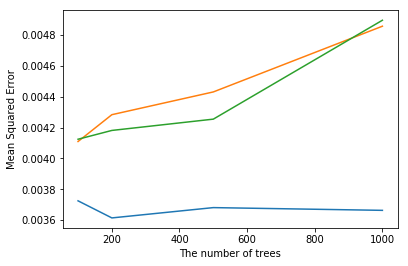

In [61]:
# Show the results of all three techniques in a single graph.
import matplotlib.pyplot as plt
tree_num = [100,200,500,1000]

plt.plot(tree_num ,rf_mse)
plt.plot(tree_num ,gb_mse)
plt.plot(tree_num ,xgb_mse)
plt.ylabel('Mean Squared Error')
plt.xlabel('The number of trees')
plt.show()